# Bento tutorial

**Author**: Clarence Mah | **Last Updated**: 3/18/2023

Here we will analyze the seqFISH+ 2019 dataset, in which 10k genes are profiled in 3T3 cells with seqFISH+. We demonstrate RNAforest (predicting RNA localization patterns) and RNAflux (spatial composition embeddings and subcellular domains).

## Setup

Load libraries and configure paths.

In [1]:
import bento as bt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

# Path to save figures
figdir = "/cellar/users/ckmah/spatial/figures"

## Load Data

Bento includes access to datasets with the package. Datasets are downloaded and stored in `data_home`, which by default is set to `~/bento-data`.

The loaded object is an `AnnData` object, structured similarly to single-cell omics analysis, where observations are cells, features are genes, and the main matrix is an expression count matrix. Bento additionally stores molecular coordinates in `uns['points']` and polygons as columns in `obs`. 

```{note}
See the docs on Bento [data structures](../howitworks) for more details.
```

In [2]:
dataset = "seqfish"
adata = bt.ds.load_dataset(dataset)
adata

AnnData object with n_obs × n_vars = 211 × 9506
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points'
    layers: 'spliced', 'unspliced'

Let's visualize RNA distributions using `bt.pl.density()`.

```{seealso}
See the [data visualization tutorial](data_visualization) for a more comprehensive guide on plotting.
```

```{note}
In general, plotting in `bento-tools` assumes datasets will have data stored from multiple fields of view (fov), which must be encoded in `adata.obs["batch"]`. The plotting functions plot a single fov at a time, which can be set with the `batch` parameter; if unspecified, the default is inferred from the first cell in `adata`.

If available, cell and nuclear shapes are plotted by default. Show additional shapes by passing them in a list to the `shapes` parameter.
```

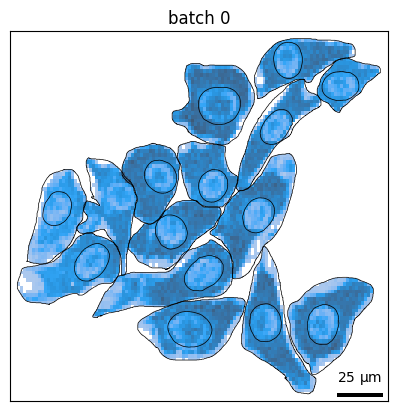

In [3]:
bt.pl.density(adata)

Or visualize a specific gene of interest with `bt.pl.points()`.

```{tip}
Plotting multiple genes can get slow quickly due to plotting the legend; if all you need is a visual, you can set `legend=False` and the plot should render more quickly.
```

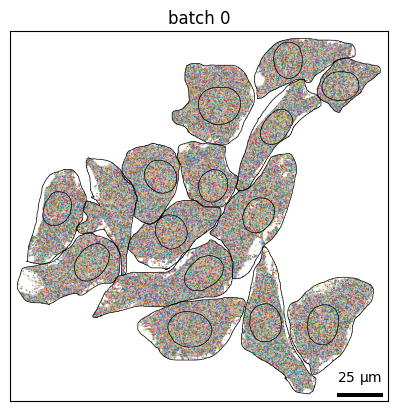

In [4]:
bt.pl.points(
    adata, hue="gene", legend=False, s=1, palette="tab20"
)

Let's filter out cells without a nucleus. There are several reasons why this may occur including missing segmentation, overlapping nuclei, or disagreement with cell segmentation. Accurate cell segmentation is a difficult task, especially in samples with high cell density (cells can overlap) and tissue sections.

In [5]:
adata = adata[adata.obs["nucleus_shape"] != None]
bt.ut.sync(adata)
adata

Trying to set attribute `._uns` of view, copying.


AnnData object with n_obs × n_vars = 179 × 9506
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points', 'point_sets'
    layers: 'spliced', 'unspliced'

Keep genes where at least 10 molecules are detected in at least one cell

In [6]:
gene_filter = (adata.X >= 10).sum(axis=0) > 0
adata = adata[:,gene_filter]
bt.ut.sync(adata)
adata

Trying to set attribute `._uns` of view, copying.


AnnData object with n_obs × n_vars = 179 × 3726
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points', 'point_sets'
    layers: 'spliced', 'unspliced'

## Spatial summary statistics

You can get a quick summary of cell and nuclear properties, including area, shape i.e. aspect ratio, and RNA density.

```{seealso}
See the [spatial features tutorial](Spatial-Features) for additional features and how to implement custom ones.
```

In [7]:
bt.tl.obs_stats(adata)

  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_aspect_ratio, cell_area, cell_density


  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + nucleus_aspect_ratio, nucleus_density, nucleus_area


Saved to /cellar/users/ckmah/spatial/figures/seqfish_obs_stats.pdf


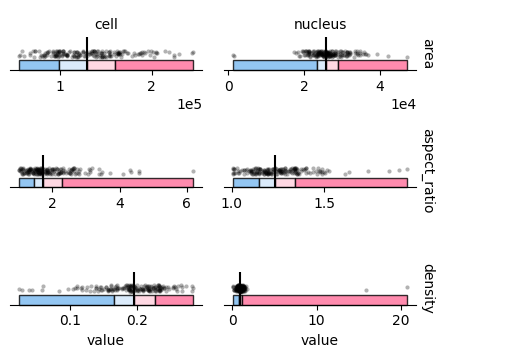

In [8]:
bt.pl.obs_stats(adata, fname=f"{figdir}/{dataset}_obs_stats.pdf")

## Predict RNA Localization Patterns

We will use the RNAforest model, to predict and annotate subcellular localization patterns. A single "sample" refers to the set of points corresponding to a given gene in a single cell. In the case that every cell expresses every gene, the number of samples is at most $n * m$ for $n$ cells and $m$ genes.

<img src="../_static/tutorial_img/rnaforest_workflow.png" alt="RNA Localization Pattern Annotation Workflow" width="800">

The five subcellular patterns we can predict are:

- **cell edge**: near the cell membrane
- **cytoplasmic**: mostly outside the nucleus in the cytoplasm
- **nuclear**: most in the nucleus
- **nuclear edge**: near the nuclear membrane, either
- **none**: none of the above patterns, more or less randomly distributed

```{seemore}
See [more details about the spatial statistics](../howitworks#spatial-features) used as input features for classification.
```

```{note}
Runtime: 90 minutes
```

In [9]:
bt.tl.lp(adata)

Calculating cell features...


  0%|          | 0/5 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_span, cell_maxy, cell_radius, cell_miny, cell_raster, cell_maxx, cell_minx
    uns:
        + cell_raster


Processing point features...


  0%|          | 0/179 [00:00<?, ?it/s]

Saving results...
Done.


AnnData object modified:
    obs:
        + cell_span, cell_maxy, cell_radius, cell_miny, cell_raster, cell_maxx, cell_minx
    uns:
        + cell_gene_features, cell_raster


Calculating cell features...


  0%|          | 0/2 [00:00<?, ?it/s]

Processing point features...


  0%|          | 0/179 [00:00<?, ?it/s]

Saving results...
Done.


AnnData object modified:
    obs:
        + cell_span, cell_maxy, cell_radius, cell_miny, cell_raster, cell_maxx, cell_minx
    uns:
        + lp, cell_gene_features, lpp, cell_raster


We can view the observed pattern frequencies to get a rough idea of how transcripts are localizing.

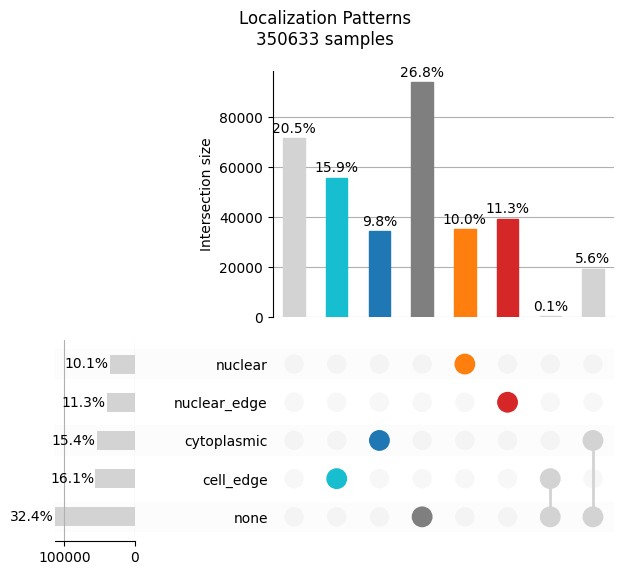

In [10]:
bt.pl.lp_dist(adata, percentage=True)

We can also visualize the localization of each gene where the point position denotes the balance between subcellular localization pattern frequencies. The color denotes the gene's most frequent pattern. Interestingly, we see a wide range of variability in localization. A large number of genes are pulled towards none while nuclear enriched genes show strong bias and a high fraction of cells.

In [11]:
bt.tl.lp_stats(adata)

AnnData object modified:
    uns:
        + lp_stats


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved to /cellar/users/ckmah/spatial/figures/seqfish_lp_genes.pdf


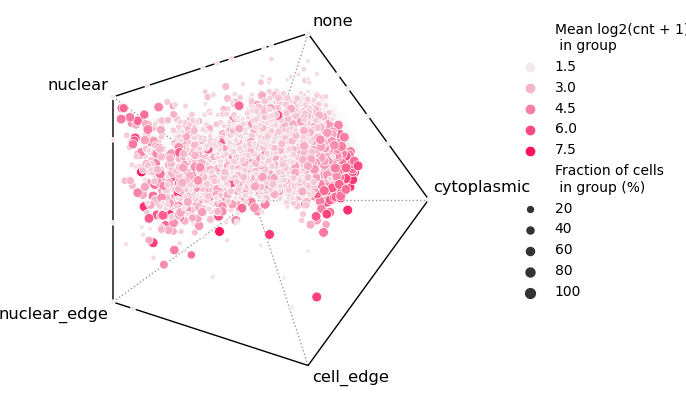

In [12]:
bt.pl.lp_genes(adata, sizes=(10, 50), fname=f"{figdir}/{dataset}_lp_genes.pdf")

## Predict subcellular domains

### RNAflux embedding

RNAflux quantifies spatial composition gradients to capture subcellular changes in expression, represented as a `[pixel x gene]` embedding. 

```{seealso}
Learn more about the algorithm [here](howitworks#rnaflux).
```

In [13]:
res = 0.1
bt.tl.flux(adata, radius=50, res=res)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

AnnData object modified:
    uns:
        + flux, flux_genes, flux_embed, flux_variance_ratio, flux_color


`bt.tl.flux()` automatically performs PCA and saves the first 10 principal components (PCs) in `uns['flux_embed']`. We can visualize the first 3 PCs by mapping them to RGB values (red = PC1, green = PC2, and blue = PC3) for each pixel.

```{tip}
The embedding is calculated at 5% unit resolution by default for speed. Higher resolution trades off speed for smoother embeddings. Note that computation time scales quadratically in relation to resolution $r$ or $O(r^{2})$ e.g. 10% resolution takes 4x longer to compute than 5%.
```

```{note}
Runtime: 5 minutes
```

Saved to /cellar/users/ckmah/spatial/figures/seqfish_flux.pdf


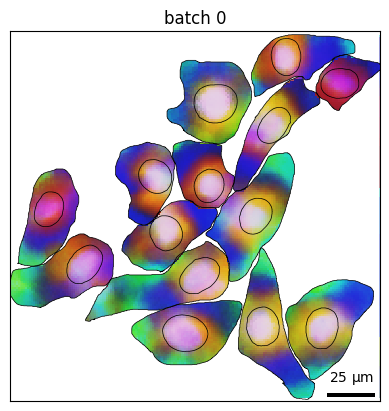

In [14]:
bt.pl.flux(
    adata,
    res=res,
    square=True,
    fname=f"{figdir}/{dataset}_flux.pdf",
)

### Fluxmaps (RNAflux domains)

To identify distinct subcellular domains in a data-driven manner, we can cluster pixels by their RNAflux embeddings. The `bt.tl.fluxmap()` function fits a self-organizing map (SOM) to the reduced PCA space for a range of cluster numbers. We use the [elbow method heuristic](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to recommend the optimal number of clusters. By default, a line plot will be rendered showing the model fit error for each cluster number and draw a vertical dotted line indicating the recommended number. 

```{note}

Determining the number of clusters is not trivial and can be highly subjective. Occasionally, no number is suggested. You can either try a wider range of cluster numbers or manually pick one. We generally recommend settling on a smaller number of clusters i.e. less than 10 for interpretability.

Runtime: 5 minutes
```

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

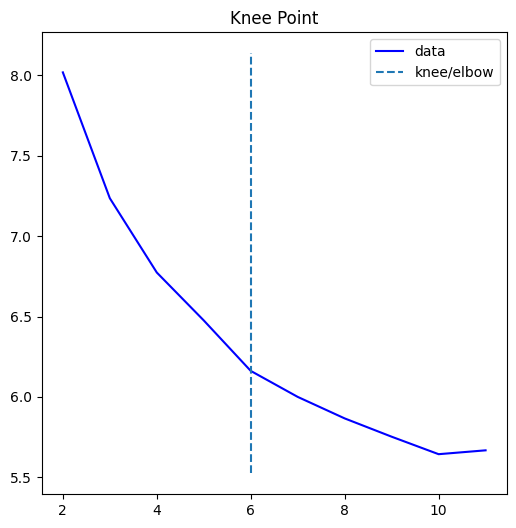

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + fluxmap5_shape, fluxmap2_shape, fluxmap6_shape, fluxmap3_shape, fluxmap4_shape, fluxmap1_shape


In [15]:
bt.tl.fluxmap(
    adata,
    num_iterations=1000,
    n_clusters=range(2, 12),
    train_size=0.2,
    res=res,
)

Now let's visualize the predicted subcellular domains. Notice how every cell contains instances of each domain (denoted by the different colors).

In [16]:
domain_palette = sns.color_palette(
    [
        "#FFD166",
        "#06D6A0",
        "#118ab2",
        "#396270",
        "#f78c6b",
        "#ef476f",
    ]
)
domain_palette

[(1.0, 0.8196078431372549, 0.4),
 (0.023529411764705882, 0.8392156862745098, 0.6274509803921569),
 (0.06666666666666667, 0.5411764705882353, 0.6980392156862745),
 (0.2235294117647059, 0.3843137254901961, 0.4392156862745098),
 (0.9686274509803922, 0.5490196078431373, 0.4196078431372549),
 (0.9372549019607843, 0.2784313725490196, 0.43529411764705883)]

Saved to /cellar/users/ckmah/spatial/figures/seqfish_fluxmap.pdf


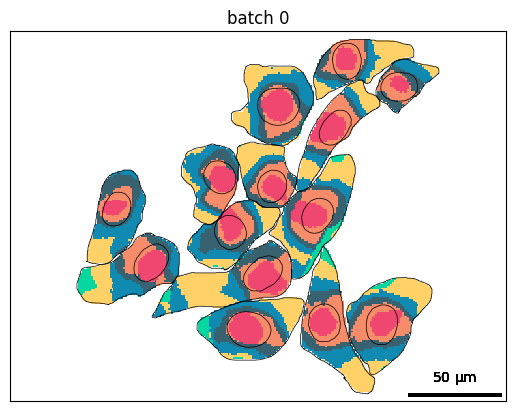

In [17]:
bt.pl.fluxmap(
    adata,
    color_style="fill",
    lw=0,
    palette=domain_palette,
    square=True,
    fname=f"{figdir}/{dataset}_fluxmap.pdf",
)

### Functional enrichment of fluxmaps

In [18]:
adata_small = adata[adata.obs["batch"] == "8"]
bt.ut.sync(adata_small)

Trying to set attribute `._uns` of view, copying.


In [19]:
adata_small.uns["flux_genes"] = [g.upper() for g in adata_small.uns["flux_genes"]]

In [20]:
bt.tl.fe_fazal2019(adata_small)

10 samples of mat are empty, they will be removed.


Running wsum on mat with 17382 samples and 3726 targets for 8 sources.
Infering activities on 2 batches.


  0%|                                                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1/2 [00:39<00:39, 39.36s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:07<00:00, 32.51s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:07<00:00, 33.54s/it]

AnnData object modified:
    uns:
        + flux_OMM, fe_ngenes, flux_ERM, flux_Nuclear Pore, flux_Nucleus, fe_stats, flux_ER Lumen, flux_Lamina, flux_Nucleolus, flux_Cytosol


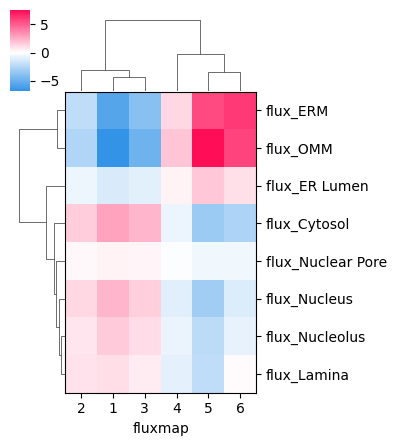

In [21]:
domains = [
    "flux_Cytosol",
    "flux_Nucleus",
    "flux_ERM",
    "flux_Nucleolus",
    "flux_ER Lumen",
    "flux_OMM",
    "flux_Nuclear Pore",
    "flux_Lamina",
]

domain_fe = pd.DataFrame(
    np.stack([adata_small.uns[d] for d in domains], axis=1),
    index=adata_small.uns["cell_raster"].index,
    columns=domains,
)

domain_fe = domain_fe.groupby(adata_small.uns["cell_raster"]["fluxmap"]).mean()
g = sns.clustermap(
    domain_fe.T,
    center=0,
    cmap=bt.colors.red2blue,
    figsize=(4, 4.5),
)
g.ax_heatmap.spines[:].set_visible(True)

rc = {
    "svg.fonttype": "none",
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    "pdf.fonttype": 42,
}
fname = f"{figdir}/{dataset}_fluxmap_fe.pdf"
with plt.rc_context(rc):
    plt.savefig(fname, dpi=400, pad_inches=0, bbox_inches="tight")

Trying to set attribute `._uns` of view, copying.


Trying to set attribute `._uns` of view, copying.


Trying to set attribute `._uns` of view, copying.


Trying to set attribute `._uns` of view, copying.


Trying to set attribute `._uns` of view, copying.


Trying to set attribute `._uns` of view, copying.


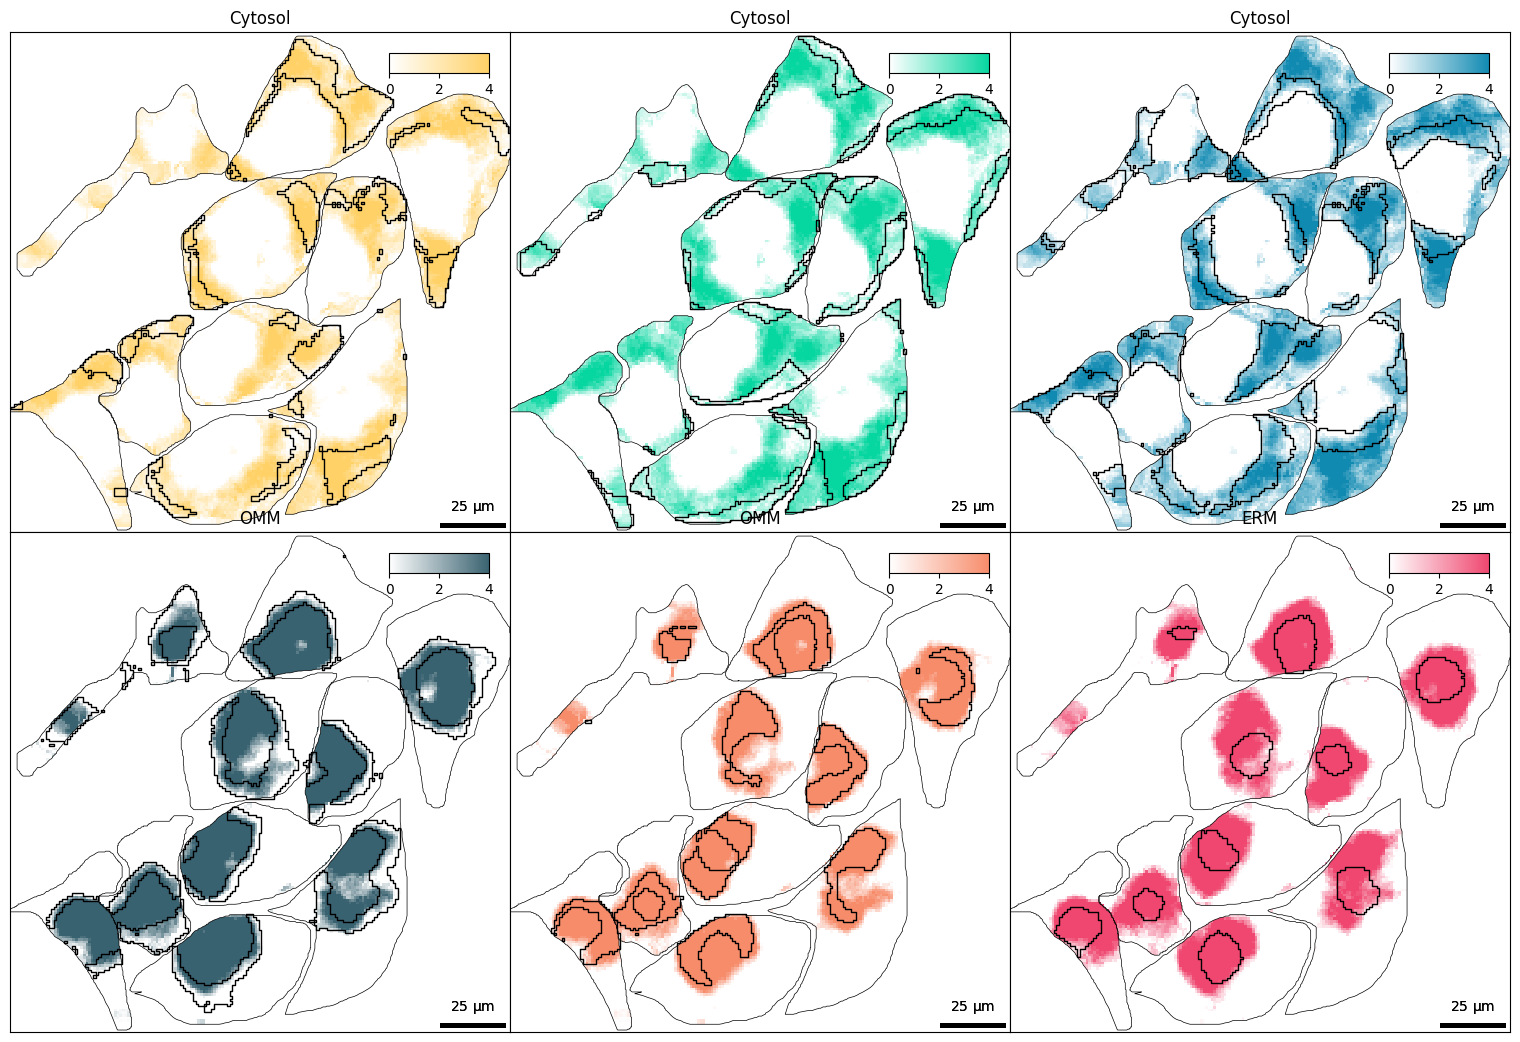

In [22]:
fluxmap2domain = domain_fe.idxmax(axis=1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for shape, ax in zip(fluxmap2domain.index, axes.flat):
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "fe", ["white", domain_palette[shape - 1]]
    )
    domain = fluxmap2domain[shape]
    bt.pl.shapes(
        adata_small,
        shapes=f"fluxmap{shape}",
        color_style="outline",
        ax=ax,
        lw=1,
    )
    bt.pl.fe(
        adata_small,
        domain,
        shapes=['cell'],
        res=0.1,
        cmap=cmap,
        ax=ax,
        title=domain.split("flux_")[1],
        square=True,
        vmin=0,
        vmax=4,
    )

# remove empty axes
for ax in axes.flat[domain_fe.shape[0] :]:
    ax.remove()
plt.subplots_adjust(wspace=0, hspace=0, bottom=0, top=1, left=0, right=1)

rc = {
    "svg.fonttype": "none",
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    "pdf.fonttype": 42,
}
fname = f"{figdir}/{dataset}_fe_all.pdf"
with plt.rc_context(rc):
    plt.savefig(fname, dpi=400, pad_inches=0, bbox_inches="tight")